In [2]:
import pandas as pd
# import pyodbc
import logging
import requests
import copy
import math
import time
import nltk
from elasticsearch import helpers

from elasticsearch import Elasticsearch


In [10]:
df_unique_index_nf = pd.read_csv('df_unique_index_nf.csv')
df_unique_index_nf

,Unnamed: 0.1,Unnamed: 0,ID,MODELO,SERIE,NUMERO_NOTA_FISCAL,DATA_EMISSAO,CNPJ_CPF_EMITENTE,RAZAO_SOCIAL_EMITENTE,NOME_FANTASIA_EMITENTE,...,DESCRICAO_PRODUTO,UNIDADE_PRODUTO,UNIDADE_PRODUTO_TRIBUTAVEL,QUANTIDADE_PRODUTO,QUANTIDADE_PRODUTO_TRIBUTAVEL,VALOR_PRODUTO,VALOR_PRODUTO_TRIBUTAVEL,CODIGO_BARRA,CODIGO_BARRA_TRIBUTAVEL,NCM
0,0,0,49537821,55,1,13870,2023-01-18 00:00:00.000,25546178000163,E. Zicolau Comercio Eletronico Me,Magazine Mega,...,Kit Eletrofita 2 Pistas 3 Metros 750V 10A,UN,UN,1.0,1.0,99.50,99.50,7901065314497,7901065314497,85444900
1,1,1,53886647,55,1,109951,2023-02-22 00:00:00.000,5677144000109,COMPLETA COMERCIO DE FERRAGENS E UTILIDADES EI...,COMPLETA,...,ABRAC TIPO U VERG 1X1/4 25PC,UN,UN,1.0,1.0,78.09,78.09,7899960444053,7899960444053,73269090
2,2,2,38357115,55,1,2927,2022-10-26 00:00:00.000,22793733000406,F PELEGRINELLI EIRELI,REI DOS PNEUS - FILIAL3,...,KIT AMORTECEDOR COMPLETO NAKATA LE,UN,PC,1.0,1.0,210.00,210.00,7890903046815,7890903046815,87088000
3,3,3,67282171,55,8,100,2023-06-02 00:00:00.000,28649167000105,A THOMAZINI COELHO FARMA LTDA,NaN,...,CEBRILIN 30MG C/30 COMP LIBBS,UND,UND,4.0,4.0,154.73,154.73,7896094202276,7896094202276,30049079
4,4,4,33006554,55,1,12023,2022-09-19 00:00:00.000,28411830000120,AGRONORTE COMERCIO E REPRESENTACAO LTDA,AGRONORTE PRODUTOS AGROPECUARIOS,...,FOICE COMUM LEVE LP,UN,UN,1.0,1.0,65.00,65.00,7898906966277,7898906966277,82019000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1124634,1124684,1124684,75293628,55,1,744,2023-07-28 00:00:00.000,15191890000648,L. L. B. R. DISTRIBUIDORA LTDA,NaN,...,FLORATTA DES COL F/SECRET 75ml (Desc. 0.51),UN,UN,1.0,1.0,93.42,93.42,7891033716418,7891033716418,33072010
1124635,1124685,1124685,75324339,55,1,750,2023-07-29 00:00:00.000,15191890000648,L. L. B. R. DISTRIBUIDORA LTDA,NaN,...,FLORATTA DES COL F/SECRET 75ml (Desc. 0.17),UN,UN,1.0,1.0,82.43,82.43,7891033716418,7891033716418,33072010
1124636,1124686,1124686,75501409,55,1,151025,2023-07-31 00:00:00.000,26554435000171,L & G ALIMENTOS DO BRASIL LTDA,MERCALE - ARV,...,LIMP PISO CIF PERFUME 900ML ENERGIZANTE UN QTD...,UN,UN,6.0,6.0,6.48,6.48,7891150071537,7891150071537,34025000
1124637,1124687,1124687,75561037,55,5,4712030,2023-07-31 00:00:00.000,14190675000317,LSI S.A.,LSI S.A.,...,LOVERS FORCEPS 18R ADULTO - GOLGRAN,UNIDAD,1,1.0,1.0,93.90,93.90,7899065804998,7899065804998,90184999


In [2]:
# es = Elasticsearch(
#     "http://150.165.75.163:9200",
#     basic_auth=("elastic", "GnlrL41DQapI3"),
#     request_timeout=999999999
# )

# es.info()
es = Elasticsearch(
    "http://150.165.75.163:9202",
    basic_auth=("elastic", "teste123"),
    request_timeout=999999999
)

es.info()


ObjectApiResponse({'name': 'es01', 'cluster_name': 'es-docker-cluster', 'cluster_uuid': '8pFe7X9oRge9WST4LcJmzw', 'version': {'number': '8.6.2', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '2d58d0f136141f03239816a4e360a8d17b6d8f29', 'build_date': '2023-02-13T09:35:20.314882762Z', 'build_snapshot': False, 'lucene_version': '9.4.2', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

In [3]:
from sentence_transformers import SentenceTransformer
modelL6V2 = SentenceTransformer('all-MiniLM-L6-v2')
modelBV2 = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
modelMult = SentenceTransformer('sentence-transformers/quora-distilbert-multilingual')
modelLASE = SentenceTransformer('sentence-transformers/LaBSE')

/home/melqui/miniconda3/envs/jupyter-env/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/home/melqui/miniconda3/envs/jupyter-env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/melqui/miniconda3/envs/jupyter-env/lib/python3.12/site-packages/sentence_transformers/models/Dense.py:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is

In [5]:
dv_relev_sample = pd.read_csv('dv_relev_sample.csv')
dv_relev_sample

,Unnamed: 0,ID,DESCRICAO_PRODUTO,CODIGO_BARRA,relevantes
0,0,37401017,Estante De Livro Livreiro Plastico Modular Mul...,7898062608721,"[(15474061, 2), (19471168, 2), (29926389, 2), ..."
1,1,24676294,PALHA ATLAS DE ACO Na0,7896380173433,"[(622386, 2), (1051610, 2), (3340068, 2), (459..."
2,2,2865424,IOGURTE POLPA NINHO MORANGO 540G,7891000261026,"[(21152, 2), (106527, 2), (817876, 2), (927131..."
3,3,19083035,"ACRILICO SEBR BASE C 3,2L SUVINIL UVA-PASSA - ...",7891260382752,"[(35412, 2), (1317892, 2), (3463646, 2), (7930..."
4,4,41266460,TESOURA PODA HOBBY - TRAMONTINA,7891117007128,"[(2749486, 2), (6490992, 2), (8493715, 2), (88..."
5,5,34370048,LIMP.CASA PERFUME AGRAD.12X500,7896040704625,"[(3147343, 2), (13576023, 2), (19446495, 2), (..."
6,6,12098037,EXTENSAO TRAMONTINA 3MT 3TOM,7891435051834,"[(28423222, 2), (32417821, 2), (37169515, 2), ..."
7,7,33306809,VARIVAX 100MG 30 S,7898133136450,"[(32408241, 2), (32412692, 2), (32517757, 2), ..."
8,8,34902493,ENGATE KRONA FLEXIVEL 1/2X50CM,7897801300841,"[(291060, 2), (1259621, 2), (1481848, 2), (442..."
9,9,47996506,JOELHO PVC EM 45 GRAUS PARA ESGOTO PRIMARIO - ...,7897801301763,"[(3520749, 2), (26152140, 2), (32709318, 2), (..."


In [6]:
dv_relev_sample['relevantes'] = None
for idx, query in dv_relev_sample.iterrows():
    codigo_barra_atual = query['CODIGO_BARRA']
    results = df_unique_index_nf[df_unique_index_nf['CODIGO_BARRA'] == codigo_barra_atual]
    dv_relev_sample['relevantes'][idx] = [(row['ID'], 2) for _, row in results.iterrows()]
dv_relev_sample = dv_relev_sample[['ID', 'DESCRICAO_PRODUTO', 'CODIGO_BARRA', 'relevantes']]
dv_relev_sample

/tmp/ipykernel_2346612/3738172136.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dv_relev_sample['relevantes'][idx] = [(row['ID'], 2) for _, row in results.iterrows()]
/tmp/ipykernel_2346612/3738172136.py:5: SettingWithCopyWarning: 
A v

,ID,DESCRICAO_PRODUTO,CODIGO_BARRA,relevantes
0,37401017,Estante De Livro Livreiro Plastico Modular Mul...,7898062608721,"[(15474061, 2), (19471168, 2), (29926389, 2), ..."
1,24676294,PALHA ATLAS DE ACO Na0,7896380173433,"[(622386, 2), (1051610, 2), (3340068, 2), (459..."
2,2865424,IOGURTE POLPA NINHO MORANGO 540G,7891000261026,"[(21152, 2), (106527, 2), (817876, 2), (927131..."
3,19083035,"ACRILICO SEBR BASE C 3,2L SUVINIL UVA-PASSA - ...",7891260382752,"[(35412, 2), (1317892, 2), (3463646, 2), (7930..."
4,41266460,TESOURA PODA HOBBY - TRAMONTINA,7891117007128,"[(2749486, 2), (6490992, 2), (8493715, 2), (88..."
5,34370048,LIMP.CASA PERFUME AGRAD.12X500,7896040704625,"[(3147343, 2), (13576023, 2), (19446495, 2), (..."
6,12098037,EXTENSAO TRAMONTINA 3MT 3TOM,7891435051834,"[(28423222, 2), (32417821, 2), (37169515, 2), ..."
7,33306809,VARIVAX 100MG 30 S,7898133136450,"[(32408241, 2), (32412692, 2), (32517757, 2), ..."
8,34902493,ENGATE KRONA FLEXIVEL 1/2X50CM,7897801300841,"[(291060, 2), (1259621, 2), (1481848, 2), (442..."
9,47996506,JOELHO PVC EM 45 GRAUS PARA ESGOTO PRIMARIO - ...,7897801301763,"[(3520749, 2), (26152140, 2), (32709318, 2), (..."


In [16]:
dv_relev_novo = dv_relev_sample.reset_index(drop =True)
dv_relev_novo['CODIGO_BARRA']

0     7898062608721
1     7896380173433
2     7891000261026
3     7891260382752
4     7891117007128
5     7896040704625
6     7891435051834
7     7898133136450
8     7897801300841
9     7897801301763
10    7891040113491
11    7896079587329
12    7500435157513
13    7895500761178
14    7891033716418
15    7898526969856
16    7898932213895
17    7898610372555
18    7891019170609
19    7898075640053
20    7908324400298
21    7891242161818
22    7896011102610
23    7899381693962
24    7891521359127
25    7893371000259
26    7891117003748
27    7899952304273
28    7891033773572
29    7891321333174
30    7500435169370
31    7891317439002
32    7898436366844
33    7894325109585
34    7896112401926
35    7891150036390
36    4005808335435
37    7896004720838
38    7804540226387
39    7898330152109
40    7891696009551
41    4013790009432
42    7898360914173
43    7891150071537
44    7891117003922
45    7908324400120
46    7899065804998
47     789109550004
48    7897016830133
49    7891035800245


In [10]:
# !export GROQ_API_KEY="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"
from groq import Groq
import os
os.environ['GROQ_API_KEY'] = "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"
api_key = os.environ.get("GROQ_API_KEY")
print(f"GROQ_API_KEY: {api_key}")
import datetime

GROQ_API_KEY: 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


In [25]:
client = Groq(api_key=os.environ.get("GROQ_API_KEY"))

def generate_synonym_descriptions(df):
    instructions = """
    ### Instruções:
    Abaixo você receberá descrições de produtos. Para cada descrição, gere apenas uma variação que se refere ao mesmo produto, respeitando os valores como altura, profundidade e volume. As unidades de medida podem ser substituídas por sua nomenclatura por extenso (por exemplo, cm para "centímetros").

    ### Exemplos:

    #### Exemplo 1:
    #### Descrição original:
    Forno Mufla Aplicação Tratamento Térmico Temperatura Máxima 1.400V Largura 600MBPS Altura 400V Profundidade 680MMHG Volume 163MM

    #### Variações:
    1. Forno Mufla para Tratamento Térmico com Temperatura Máxima de 1.400 Volts, Largura de 600 Megabits por Segundo, Altura de 400 Volts, Profundidade de 680 Milímetros de Mercúrio e Volume de 163 Milímetros
    2. Forno Mufla para Processos Térmicos, alcançando até 1.400V, com Largura de 600MBPS, Altura de 400V, Profundidade de 680MMHG e Volume de 163MM
    3. Forno Mufla adequado para Tratamento Térmico com Temperatura Máxima de 1.400V, Largura de 600MBPS, Altura de 400V, Profundidade de 680MMHG e Volume de 163MM

    #### Exemplo 2:
    #### Descrição original:
    Geladeira Industrial Capacidade 500L Temperatura mínima -20°C Temperatura máxima 10°C Consumo energético 200W Dimensões 180X70X60CM Peso 80KG

    #### Variações:
    1. Geladeira Industrial com Capacidade de 500 Litros, Temperatura Mínima de -20 Graus Celsius e Máxima de 10 Graus Celsius, Consumo Energético de 200 Watts, Dimensões de 180 por 70 por 60 Centímetros e Peso de 80 Quilogramas
    2. Refrigerador Industrial com Volume de 500L, suportando Temperaturas de -20°C a 10°C, Consumo de Energia de 200W, Medidas de 180X70X60CM e Peso de 80KG
    3. Unidade de Refrigeração Industrial com Capacidade de 500L, operando entre -20°C e 10°C, Consumo de 200W, Dimensões de 180X70X60CM e Massa de 80KG

    ### Agora, gere um prompt de resposta sem nenhuma mensagem de introdução, apenas apresente uma resposta no seguinte formato:
    1.
    Gere apenas uma descrição contendo sinônimos para o seguinte produto:
    """

    data = []

    for index, row in df.iterrows():
        product_description = f"####\n{row['DESCRICAO_PRODUTO']}\n\n####:\n"
        completion = client.chat.completions.create(
            model="llama3-70b-8192",
            messages=[
                {
                    "role": "user",
                    "content": instructions + product_description
                }
            ],
            temperature=0.9,
            max_tokens=2048,
            top_p=0.95,
            stream=False,
            stop=None,
        )
        
        generated_variation = completion.choices[0].message.content.strip()
        print(generated_variation)

        data.append({
            "query": row['DESCRICAO_PRODUTO'],
            "com_sinonimos": generated_variation
        })

        data.append({
            "query": row['DESCRICAO_PRODUTO'],
            "com_sinonimos": generated_variation
        })
    
        data.append({
            "query": row['DESCRICAO_PRODUTO'],
            "com_sinonimos": generated_variation
        })

        data.append({
            "query": row['DESCRICAO_PRODUTO'],
            "com_sinonimos": generated_variation
        })
        
    df_sinonimo = pd.DataFrame(data)
    
    return df_sinonimo



In [26]:
df_sinonimos = generate_synonym_descriptions(dv_relev_novo)
df_sinonimos

1. Estante de Armazenamento Polivalente feita de Plástico, Modular e com Múltiplas Funções, composta por 5 Prateleiras.
1. Fardo de Palha Atlas de Aço Inox, modelo Na0.
1. Iogurte de Polpa de Morango da marca Ninho, com Peso Líquido de 540 Gramas.
1. Acabamento de Acrílico Sebr Base C, com volume de 3,2 Litros, modelo Suvil Uva-Passa - 623687, com efeito Toque de Luz / Ilumina.
1. Tesoura de Poda para Hobby, marca Tramontina.
1. Limpeza Casa Perfume Agradável com 12 Unidades de 500 Mililitros Cada
1. Extensão de Alcance Tramontina de 3 Metros e 3 Toneladas.
1. Varivax 100 Miligramas para 30 Doses
1. Conector Flexível Engate Krona de 1/2 Polegada por 50 Centímetros.
1. Conector de Ângulo de 45 Graus em PVC para Esgoto Primário, com Diâmetro Nominal de 50 Milímetros
1. Esponja Scotch Brite Mágica para Limpeza, também conhecida como Esponja de Fibra Abrasiva Mágica Scotch Brite.
1. Doce de Leite Tradicional Seleção Especial de 400 Gramas
1. Fralda Descartável Pampers Splasher modelo PM12


,query,com_sinonimos
0,Estante De Livro Livreiro Plastico Modular Mul...,1. Estante de Armazenamento Polivalente feita ...
1,Estante De Livro Livreiro Plastico Modular Mul...,1. Estante de Armazenamento Polivalente feita ...
2,Estante De Livro Livreiro Plastico Modular Mul...,1. Estante de Armazenamento Polivalente feita ...
3,Estante De Livro Livreiro Plastico Modular Mul...,1. Estante de Armazenamento Polivalente feita ...
4,PALHA ATLAS DE ACO Na0,"1. Fardo de Palha Atlas de Aço Inox, modelo Na0."
...,...,...
195,LAVADORA 10 COLORMAQ LCS10 BR,1. Máquina de Lavar Roupa 10 Kg ColorMaq LCS10 BR
196,VEJA DESENG 500ML,1. Frasco de Vidro para Armazenamento de Líqui...
197,VEJA DESENG 500ML,1. Frasco de Vidro para Armazenamento de Líqui...
198,VEJA DESENG 500ML,1. Frasco de Vidro para Armazenamento de Líqui...


In [27]:
import pandas as pd

def tratar_descricao(df, coluna):
    def remover_prefixo(descricao):
        if descricao.startswith("1. "):
            return descricao[3:]
        return descricao

    df[coluna] = df[coluna].apply(remover_prefixo)
    return df


In [28]:
df_sinonimos_llam = tratar_descricao(df_sinonimos, 'com_sinonimos')
df_sinonimos_llam

,query,com_sinonimos
0,Estante De Livro Livreiro Plastico Modular Mul...,Estante de Armazenamento Polivalente feita de ...
1,Estante De Livro Livreiro Plastico Modular Mul...,Estante de Armazenamento Polivalente feita de ...
2,Estante De Livro Livreiro Plastico Modular Mul...,Estante de Armazenamento Polivalente feita de ...
3,Estante De Livro Livreiro Plastico Modular Mul...,Estante de Armazenamento Polivalente feita de ...
4,PALHA ATLAS DE ACO Na0,"Fardo de Palha Atlas de Aço Inox, modelo Na0."
...,...,...
195,LAVADORA 10 COLORMAQ LCS10 BR,Máquina de Lavar Roupa 10 Kg ColorMaq LCS10 BR
196,VEJA DESENG 500ML,Frasco de Vidro para Armazenamento de Líquidos...
197,VEJA DESENG 500ML,Frasco de Vidro para Armazenamento de Líquidos...
198,VEJA DESENG 500ML,Frasco de Vidro para Armazenamento de Líquidos...


In [35]:
df_sinonimos_llam.to_csv('ruidosCsvEmbeddings/sinonimos_llama.csv')

In [14]:
queries = []
for idx, row in dv_relev_novo.iterrows():
    queries.append({'idx':idx,'query': row['DESCRICAO_PRODUTO'], 'page_size': 100})

result_queries = []
for q in queries:
     q_allmini = copy.deepcopy(q)
     q_allmini['abordagem'] = 'all_mini'
     result_queries.append(q_allmini)
     
     q_bv2 = copy.deepcopy(q)
     q_bv2['abordagem'] = 'q_bv2'
     result_queries.append(q_bv2)

     q_mpnet = copy.deepcopy(q)
     q_mpnet['abordagem'] = 'mpnet'
     result_queries.append(q_mpnet)
     
     q_labase = copy.deepcopy(q)
     q_labase['abordagem'] = 'labase'
     result_queries.append(q_labase)

df_queries_relv = pd.DataFrame(result_queries)
df_queries_relv

,idx,query,page_size,abordagem
0,0,Estante De Livro Livreiro Plastico Modular Mul...,100,all_mini
1,0,Estante De Livro Livreiro Plastico Modular Mul...,100,q_bv2
2,0,Estante De Livro Livreiro Plastico Modular Mul...,100,mpnet
3,0,Estante De Livro Livreiro Plastico Modular Mul...,100,labase
4,1,PALHA ATLAS DE ACO Na0,100,all_mini
...,...,...,...,...
195,48,LAVADORA 10 COLORMAQ LCS10 BR,100,labase
196,49,VEJA DESENG 500ML,100,all_mini
197,49,VEJA DESENG 500ML,100,q_bv2
198,49,VEJA DESENG 500ML,100,mpnet


In [38]:
df_sinonimos_llam = pd.read_csv('ruidosCsvEmbeddings/sinonimos_llama.csv')
df_erros_dig = pd.read_csv('ruidosCsvEmbeddings/erro_digt.csv')
df_termos_reord = pd.read_csv('ruidosCsvEmbeddings/reordenados.csv')


In [39]:
df_queries_relv['sinonimos'] = df_sinonimos_llam['com_sinonimos']
df_queries_relv['erros_digitacao'] = df_erros_dig['com_erro']
df_queries_relv['reordenados'] = df_termos_reord['com_nova_ordem']
df_queries_relv

,idx,query,page_size,abordagem,sinonimos,erros_digitacao,reordenados
0,0,Estante De Livro Livreiro Plastico Modular Mul...,100,all_mini,Estante de Armazenamento Polivalente feita de ...,Estente De Livo Livreiro Plástico Modular Mult...,Livreiro Plastico Estante De Livro Modular Mul...
1,0,Estante De Livro Livreiro Plastico Modular Mul...,100,q_bv2,Estante de Armazenamento Polivalente feita de ...,Estente De Livo Livreiro Plástico Modular Mult...,Livreiro Plastico Estante De Livro Modular Mul...
2,0,Estante De Livro Livreiro Plastico Modular Mul...,100,mpnet,Estante de Armazenamento Polivalente feita de ...,Estente De Livo Livreiro Plástico Modular Mult...,Livreiro Plastico Estante De Livro Modular Mul...
3,0,Estante De Livro Livreiro Plastico Modular Mul...,100,labase,Estante de Armazenamento Polivalente feita de ...,Estente De Livo Livreiro Plástico Modular Mult...,Livreiro Plastico Estante De Livro Modular Mul...
4,1,PALHA ATLAS DE ACO Na0,100,all_mini,"Fardo de Palha Atlas de Aço Inox, modelo Na0.",PALNA ATLAS DE AÇO Nao,PALHA Na0 ATLAS DE ACO
...,...,...,...,...,...,...,...
195,48,LAVADORA 10 COLORMAQ LCS10 BR,100,labase,Máquina de Lavar Roupa 10 Kg ColorMaq LCS10 BR,LAVAD 10 COLORMAQ LCS10 BR,COLORMAQ LCS10 BR 10 LAVADORA
196,49,VEJA DESENG 500ML,100,all_mini,Frasco de Vidro para Armazenamento de Líquidos...,VEJ DESENG 500ML,DESENG 500ML VEJA
197,49,VEJA DESENG 500ML,100,q_bv2,Frasco de Vidro para Armazenamento de Líquidos...,VEJ DESENG 500ML,DESENG 500ML VEJA
198,49,VEJA DESENG 500ML,100,mpnet,Frasco de Vidro para Armazenamento de Líquidos...,VEJ DESENG 500ML,DESENG 500ML VEJA


In [40]:
df_queries_relv.isnull().sum()

idx                0
query              0
page_size          0
abordagem          0
sinonimos          0
erros_digitacao    0
reordenados        0
dtype: int64

In [42]:
df_queries_relv.to_csv('ruidosCsvEmbeddings/queries_teste_embeddings.csv')

In [45]:
from requests.auth import HTTPBasicAuth
logging.basicConfig(filename= 'experiment_relv_embeddings.log',
    filemode='a',
    format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
    datefmt='%H:%M:%S',
    level=logging.DEBUG)

def run(file):
    total_time = 0
    processed_queries = 0
    experiment_queries = pd.read_csv(file)
    for key, value in experiment_queries.iterrows():
        if(key % 20 == 0):
            print('key', key)
        # print('value', value)

        logging.info(f'Iniciando processamento da query {value["query"]} com pagina de tamanho {value["page_size"]}')
        try:
            for i in ['query', 'sinonimos', 'erros_digitacao', 'reordenados']:
                match_query = ''
                query = ''        
                if(value['abordagem']) == 'all_mini':
                    index_consulta = 'index_s_nf'
                    match_query = modelL6V2.encode(value[i])
                    
                    query = {
                        "query": {
                            "script_score": {
                                "query": {"match_all": {}},
                                "script": {
                                    "source": "cosineSimilarity(params.query_vector, 'all_mini_base_vector') + 1.0",
                                    "params": {"query_vector": match_query.tolist()}
                                }
                            }
                        },"size": 100
                    }
                elif(value['abordagem']) == 'q_bv2':
                    index_consulta = 'index_s_nf'
                    match_query = modelBV2.encode(value[i])
                    
                    query = {
                        "query": {
                            "script_score": {
                                "query": {"match_all": {}},
                                "script": {
                                    "source": "cosineSimilarity(params.query_vector, 'bv2_base_vector') + 1.0",
                                    "params": {"query_vector": match_query.tolist()}
                                }
                            }
                        },"size": 100
                    }

                elif(value['abordagem']) == 'mpnet':
                    index_consulta = 'index_s_nf'
                    match_query = modelMult.encode(value[i])
                    
                    query = {
                        "query": {
                            "script_score": {
                                "query": {"match_all": {}},
                                "script": {
                                    "source": "cosineSimilarity(params.query_vector, 'mpnet_base_vector') + 1.0",
                                    "params": {"query_vector": match_query.tolist()}
                                }
                            }
                        },"size": 100
                    }
                elif(value['abordagem']) == 'labase':
                    index_consulta = 'index_s_nf'
                    match_query = modelLASE.encode(value[i])
                    
                    query = {
                        "query": {
                            "script_score": {
                                "query": {"match_all": {}},
                                "script": {
                                    "source": "cosineSimilarity(params.query_vector, 'labase_base_vector') + 1.0",
                                    "params": {"query_vector": match_query.tolist()}
                                }
                            }
                        },"size": 100
                    }    

                # else:
                #     index_consulta = 'index_lex_nf'
                #     match_query = value[i]
                    
                #     query = {
                #         "query": {
                #             "match": {
                #                 "descricao_produto": match_query
                #             }
                #         },"size": 100
                #     }              
        
                sucess = False
                retry_times = 0
                # print('abordagem', value['abordagem'])

                while(not sucess and retry_times < 10):

                    start_time = time.perf_counter()
                    result = requests.get('http://150.165.75.163:9202/' + index_consulta + '/_search', json=query, headers={'Content-type': 'application/json'},
                                          auth=HTTPBasicAuth('elastic', 'teste123'))
                    time_elapsed = time.perf_counter() - start_time
                    total_time += time_elapsed
                    # print('result', result)

                    if result.status_code == requests.codes.ok:
                        sucess = True
                    else:
                        retry_times += 1
                    # print('result', result)
                processed_queries += 1
                result_query = 'result_' + i 
                # print('query', result.content)

                experiment_queries.loc[key, result_query] = result.content.decode('utf-8')

                remaining_time = (total_time / processed_queries) * (len(experiment_queries) - processed_queries)

                logging.info(f'A query levou {time_elapsed:.6f}s')
                logging.info(f'Faltam aproximadamente {int(remaining_time // 3600)}h, {int((remaining_time % 3600) // 60)}m e {math.floor(remaining_time % 60)}s')
            
        except Exception as error:
            logging.error(f'Erro na consulta: {error}')
    experiment_queries.to_csv('queries_result_relv_embd.csv')



In [46]:
run('/mnt/DADOS/melqui/busca-smt/ruidosCsvEmbeddings/queries_teste_embeddings.csv')

key 0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

key 20


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

key 40


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

key 60


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

key 80


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

key 100


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

key 120


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

key 140


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

key 160


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

key 180


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
results = pd.read_csv('ruidosCsvEmbeddings/queries_result_relv_embd.csv')
results

,Unnamed: 0.1,Unnamed: 0,idx,query,page_size,abordagem,sinonimos,erros_digitacao,reordenados,result_query,result_sinonimos,result_erros_digitacao,result_reordenados
0,0,0,0,Estante De Livro Livreiro Plastico Modular Mul...,100,all_mini,Estante de Armazenamento Polivalente feita de ...,Estente De Livo Livreiro Plástico Modular Mult...,Livreiro Plastico Estante De Livro Modular Mul...,"{""took"":153,""timed_out"":false,""_shards"":{""tota...","{""took"":193,""timed_out"":false,""_shards"":{""tota...","{""took"":181,""timed_out"":false,""_shards"":{""tota...","{""took"":199,""timed_out"":false,""_shards"":{""tota..."
1,1,1,0,Estante De Livro Livreiro Plastico Modular Mul...,100,q_bv2,Estante de Armazenamento Polivalente feita de ...,Estente De Livo Livreiro Plástico Modular Mult...,Livreiro Plastico Estante De Livro Modular Mul...,"{""took"":332,""timed_out"":false,""_shards"":{""tota...","{""took"":370,""timed_out"":false,""_shards"":{""tota...","{""took"":343,""timed_out"":false,""_shards"":{""tota...","{""took"":283,""timed_out"":false,""_shards"":{""tota..."
2,2,2,0,Estante De Livro Livreiro Plastico Modular Mul...,100,mpnet,Estante de Armazenamento Polivalente feita de ...,Estente De Livo Livreiro Plástico Modular Mult...,Livreiro Plastico Estante De Livro Modular Mul...,"{""took"":297,""timed_out"":false,""_shards"":{""tota...","{""took"":293,""timed_out"":false,""_shards"":{""tota...","{""took"":295,""timed_out"":false,""_shards"":{""tota...","{""took"":303,""timed_out"":false,""_shards"":{""tota..."
3,3,3,0,Estante De Livro Livreiro Plastico Modular Mul...,100,labase,Estante de Armazenamento Polivalente feita de ...,Estente De Livo Livreiro Plástico Modular Mult...,Livreiro Plastico Estante De Livro Modular Mul...,"{""took"":352,""timed_out"":false,""_shards"":{""tota...","{""took"":335,""timed_out"":false,""_shards"":{""tota...","{""took"":346,""timed_out"":false,""_shards"":{""tota...","{""took"":346,""timed_out"":false,""_shards"":{""tota..."
4,4,4,1,PALHA ATLAS DE ACO Na0,100,all_mini,"Fardo de Palha Atlas de Aço Inox, modelo Na0.",PALNA ATLAS DE AÇO Nao,PALHA Na0 ATLAS DE ACO,"{""took"":195,""timed_out"":false,""_shards"":{""tota...","{""took"":182,""timed_out"":false,""_shards"":{""tota...","{""took"":162,""timed_out"":false,""_shards"":{""tota...","{""took"":160,""timed_out"":false,""_shards"":{""tota..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,195,48,LAVADORA 10 COLORMAQ LCS10 BR,100,labase,Máquina de Lavar Roupa 10 Kg ColorMaq LCS10 BR,LAVAD 10 COLORMAQ LCS10 BR,COLORMAQ LCS10 BR 10 LAVADORA,"{""took"":295,""timed_out"":false,""_shards"":{""tota...","{""took"":298,""timed_out"":false,""_shards"":{""tota...","{""took"":296,""timed_out"":false,""_shards"":{""tota...","{""took"":308,""timed_out"":false,""_shards"":{""tota..."
196,196,196,49,VEJA DESENG 500ML,100,all_mini,Frasco de Vidro para Armazenamento de Líquidos...,VEJ DESENG 500ML,DESENG 500ML VEJA,"{""took"":157,""timed_out"":false,""_shards"":{""tota...","{""took"":165,""timed_out"":false,""_shards"":{""tota...","{""took"":153,""timed_out"":false,""_shards"":{""tota...","{""took"":151,""timed_out"":false,""_shards"":{""tota..."
197,197,197,49,VEJA DESENG 500ML,100,q_bv2,Frasco de Vidro para Armazenamento de Líquidos...,VEJ DESENG 500ML,DESENG 500ML VEJA,"{""took"":289,""timed_out"":false,""_shards"":{""tota...","{""took"":294,""timed_out"":false,""_shards"":{""tota...","{""took"":293,""timed_out"":false,""_shards"":{""tota...","{""took"":294,""timed_out"":false,""_shards"":{""tota..."
198,198,198,49,VEJA DESENG 500ML,100,mpnet,Frasco de Vidro para Armazenamento de Líquidos...,VEJ DESENG 500ML,DESENG 500ML VEJA,"{""took"":332,""timed_out"":false,""_shards"":{""tota...","{""took"":304,""timed_out"":false,""_shards"":{""tota...","{""took"":322,""timed_out"":false,""_shards"":{""tota...","{""took"":296,""timed_out"":false,""_shards"":{""tota..."


In [5]:
results.isnull().sum()

Unnamed: 0.1              0
Unnamed: 0                0
idx                       0
query                     0
page_size                 0
abordagem                 0
sinonimos                 0
erros_digitacao           0
reordenados               0
result_query              0
result_sinonimos          0
result_erros_digitacao    0
result_reordenados        0
dtype: int64

In [6]:
import json
for i in ['query', 'sinonimos', 'erros_digitacao', 'reordenados']:
    result_query = 'result_' + i
    # print(result_query)
    # print(results[result_query])
    results[result_query] = results.apply(lambda row: json.loads(row[result_query]), axis=1)

# MÉTRICAS

In [7]:
def precision(results, expected):
    hits = 0
    lista = [x[0] for x in expected]
    for result in results:
        if result['id'] in lista:
            hits += 1
    if len(results) == 0:
        return 0
    precision_value = hits / len(results)
    return precision_value


In [8]:
def recall(results, expected, abordagem):
    expected_ids = set(map(lambda x: x[0], expected))
    returned_ids = set(map(lambda x: x['id'], results))
    intersection = expected_ids.intersection(returned_ids)
    recaal = len(intersection) / len(expected) if len(expected) > 0 else 0
   
    return recaal

In [14]:
def is_similar(desc1, desc2):
    vectors = tfidf_vectorizer.transform([desc1, desc2])

    vector_emb1 = modelL6V2.encode(desc1) 
    vector_emb1 = vector_emb1.reshape(1, -1)

    vector_emb2 = modelL6V2.encode(desc2)
    vector_emb2 = vector_emb2.reshape(1, -1)
    
    cosine_dist_emb = cosine_similarity(vector_emb1, vector_emb2)
    cosine_dist_tf_idf = cosine_similarity(vectors[0], vectors[1])
    value_cosi =  max(cosine_dist_tf_idf, cosine_dist_emb)
    if value_cosi > 0.7:
        return True
    else:
        return 

In [15]:
def ndcg(results, expected, query):
    annoted_results = []
    for result in results:
        r_copy = copy.deepcopy(result)
        filtered = list(filter(lambda x: x[0] == result['id'], expected))
        r_copy['relevance'] = filtered[0][1] if len(filtered) > 0 else 1 if is_similar(result['descricao_produto'], query) else 0
        #r_copy['relevance'] = filtered[0][1] if len(filtered) > 0 else 0
        annoted_results.append(r_copy)
    
    dcg = 0
    idcg = 0
    sorted_results = sorted(annoted_results, key=lambda x: x['relevance'], reverse=True)
    for i in range(len(results)):
        dcg += (2**annoted_results[i]['relevance'] - 1) / math.log2(i + 2)
        idcg += (2**sorted_results[i]['relevance'] - 1) / math.log2(i + 2)
    if idcg == 0: return 0
    return dcg / idcg

In [16]:
results

,Unnamed: 0.1,Unnamed: 0,idx,query,page_size,abordagem,sinonimos,erros_digitacao,reordenados,result_query,result_sinonimos,result_erros_digitacao,result_reordenados
0,0,0,0,Estante De Livro Livreiro Plastico Modular Mul...,100,all_mini,Estante de Armazenamento Polivalente feita de ...,Estente De Livo Livreiro Plástico Modular Mult...,Livreiro Plastico Estante De Livro Modular Mul...,"{'took': 153, 'timed_out': False, '_shards': {...","{'took': 193, 'timed_out': False, '_shards': {...","{'took': 181, 'timed_out': False, '_shards': {...","{'took': 199, 'timed_out': False, '_shards': {..."
1,1,1,0,Estante De Livro Livreiro Plastico Modular Mul...,100,q_bv2,Estante de Armazenamento Polivalente feita de ...,Estente De Livo Livreiro Plástico Modular Mult...,Livreiro Plastico Estante De Livro Modular Mul...,"{'took': 332, 'timed_out': False, '_shards': {...","{'took': 370, 'timed_out': False, '_shards': {...","{'took': 343, 'timed_out': False, '_shards': {...","{'took': 283, 'timed_out': False, '_shards': {..."
2,2,2,0,Estante De Livro Livreiro Plastico Modular Mul...,100,mpnet,Estante de Armazenamento Polivalente feita de ...,Estente De Livo Livreiro Plástico Modular Mult...,Livreiro Plastico Estante De Livro Modular Mul...,"{'took': 297, 'timed_out': False, '_shards': {...","{'took': 293, 'timed_out': False, '_shards': {...","{'took': 295, 'timed_out': False, '_shards': {...","{'took': 303, 'timed_out': False, '_shards': {..."
3,3,3,0,Estante De Livro Livreiro Plastico Modular Mul...,100,labase,Estante de Armazenamento Polivalente feita de ...,Estente De Livo Livreiro Plástico Modular Mult...,Livreiro Plastico Estante De Livro Modular Mul...,"{'took': 352, 'timed_out': False, '_shards': {...","{'took': 335, 'timed_out': False, '_shards': {...","{'took': 346, 'timed_out': False, '_shards': {...","{'took': 346, 'timed_out': False, '_shards': {..."
4,4,4,1,PALHA ATLAS DE ACO Na0,100,all_mini,"Fardo de Palha Atlas de Aço Inox, modelo Na0.",PALNA ATLAS DE AÇO Nao,PALHA Na0 ATLAS DE ACO,"{'took': 195, 'timed_out': False, '_shards': {...","{'took': 182, 'timed_out': False, '_shards': {...","{'took': 162, 'timed_out': False, '_shards': {...","{'took': 160, 'timed_out': False, '_shards': {..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,195,48,LAVADORA 10 COLORMAQ LCS10 BR,100,labase,Máquina de Lavar Roupa 10 Kg ColorMaq LCS10 BR,LAVAD 10 COLORMAQ LCS10 BR,COLORMAQ LCS10 BR 10 LAVADORA,"{'took': 295, 'timed_out': False, '_shards': {...","{'took': 298, 'timed_out': False, '_shards': {...","{'took': 296, 'timed_out': False, '_shards': {...","{'took': 308, 'timed_out': False, '_shards': {..."
196,196,196,49,VEJA DESENG 500ML,100,all_mini,Frasco de Vidro para Armazenamento de Líquidos...,VEJ DESENG 500ML,DESENG 500ML VEJA,"{'took': 157, 'timed_out': False, '_shards': {...","{'took': 165, 'timed_out': False, '_shards': {...","{'took': 153, 'timed_out': False, '_shards': {...","{'took': 151, 'timed_out': False, '_shards': {..."
197,197,197,49,VEJA DESENG 500ML,100,q_bv2,Frasco de Vidro para Armazenamento de Líquidos...,VEJ DESENG 500ML,DESENG 500ML VEJA,"{'took': 289, 'timed_out': False, '_shards': {...","{'took': 294, 'timed_out': False, '_shards': {...","{'took': 293, 'timed_out': False, '_shards': {...","{'took': 294, 'timed_out': False, '_shards': {..."
198,198,198,49,VEJA DESENG 500ML,100,mpnet,Frasco de Vidro para Armazenamento de Líquidos...,VEJ DESENG 500ML,DESENG 500ML VEJA,"{'took': 332, 'timed_out': False, '_shards': {...","{'took': 304, 'timed_out': False, '_shards': {...","{'took': 322, 'timed_out': False, '_shards': {...","{'took': 296, 'timed_out': False, '_shards': {..."


# OBTENDO PONTUAÇÃO

In [17]:
df_geral = []

In [18]:
import ast
ruidos = ['query', 'sinonimos', 'erros_digitacao', 'reordenados']
queries_df = pd.read_csv('dv_relev_sample.csv')
queries_df['relevantes'] = queries_df.apply(lambda row: ast.literal_eval(row['relevantes']), axis=1)

processed = 0
size = len(results)
size_queries =  [1,2,3,5,10,20,25,30,40,50]

for size_q in size_queries:
    results_metricas = pd.DataFrame()
    results_metricas['abordagem'] = None
    results_metricas['size_page'] = None
    
    for i in ruidos:
        results_metricas['precision_' + i] = None
        results_metricas['recall_' + i] = None
        results_metricas['f1-score_' + i] = None
        results_metricas['ndcg_' + i] = None
    for idx, row in results.iterrows():
        results_metricas.loc[idx, 'size_page'] = size_q
                
        processed += 1
        abord = results.loc[idx, 'abordagem']
        expected = queries_df.loc[row['idx'], 'relevantes']
        abordagem = results.loc[idx, 'abordagem']
        results_metricas.loc[idx, 'abordagem'] = abordagem
        if processed % 100 == 0:
            print(f'{processed} de {size} ({(processed/size)*1000:.2f}%)')
        for i in ruidos:
            result = row['result_' + i]
            items = result['hits']['hits']
            query_expected = queries_df.loc[row['idx'], 'DESCRICAO_PRODUTO']
            if items is not None:
                conteudos = [objeto['_source'] for objeto in items]
                precision_column = 'precision_' + i
                recall_column = 'recall_' + i
                conteudosSlice = conteudos[:size_q] 
                results_metricas.loc[idx, 'precision_' + i] = precision(conteudosSlice, expected)
                results_metricas.loc[idx, 'recall_' + i] = recall(conteudosSlice, expected, abordagem)
                results_metricas.loc[idx, 'f1-score_' + i] = (2 * results_metricas.loc[idx, precision_column] * results_metricas.loc[idx, recall_column]) / (results_metricas.loc[idx, precision_column] + results_metricas.loc[idx, recall_column]) if results_metricas.loc[idx, precision_column] + results_metricas.loc[idx, recall_column] > 0 else 0
                results_metricas.loc[idx, 'ndcg_' + i] = ndcg(conteudosSlice, expected, query_expected)
    df_geral.append(results_metricas)
df_por_sizes = pd.concat(df_geral)

100 de 200 (500.00%)
200 de 200 (1000.00%)
300 de 200 (1500.00%)
400 de 200 (2000.00%)
500 de 200 (2500.00%)
600 de 200 (3000.00%)
700 de 200 (3500.00%)
800 de 200 (4000.00%)
900 de 200 (4500.00%)
1000 de 200 (5000.00%)
1100 de 200 (5500.00%)
1200 de 200 (6000.00%)
1300 de 200 (6500.00%)
1400 de 200 (7000.00%)
1500 de 200 (7500.00%)
1600 de 200 (8000.00%)
1700 de 200 (8500.00%)
1800 de 200 (9000.00%)
1900 de 200 (9500.00%)
2000 de 200 (10000.00%)


In [6]:
# df_por_sizes.to_csv('ruidosCsvEmbeddingsdf_results_embeddings_NF.csv')
df_por_sizes= pd.read_csv("ruidosCsvEmbeddings/df_results_embeddings_NF.csv")
df_por_sizes

,Unnamed: 0,abordagem,size_page,precision_query,recall_query,f1-score_query,ndcg_query,precision_sinonimos,recall_sinonimos,f1-score_sinonimos,ndcg_sinonimos,precision_erros_digitacao,recall_erros_digitacao,f1-score_erros_digitacao,ndcg_erros_digitacao,precision_reordenados,recall_reordenados,f1-score_reordenados,ndcg_reordenados
0,0,all_mini,1,1.00,0.083333,0.153846,1.000000,0.00,0.000000,0.000000,0.000000,1.00,0.083333,0.153846,1.000000,1.00,0.083333,0.153846,1.000000
1,1,q_bv2,1,1.00,0.083333,0.153846,1.000000,0.00,0.000000,0.000000,0.000000,1.00,0.083333,0.153846,1.000000,1.00,0.083333,0.153846,1.000000
2,2,mpnet,1,0.00,0.000000,0.000000,0.000000,1.00,0.083333,0.153846,1.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
3,3,labase,1,1.00,0.083333,0.153846,1.000000,1.00,0.083333,0.153846,1.000000,1.00,0.083333,0.153846,1.000000,1.00,0.083333,0.153846,1.000000
4,4,all_mini,1,1.00,0.083333,0.153846,1.000000,1.00,0.083333,0.153846,1.000000,1.00,0.083333,0.153846,1.000000,1.00,0.083333,0.153846,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,195,labase,50,0.10,0.833333,0.178571,0.763808,0.08,0.666667,0.142857,0.675212,0.12,1.000000,0.214286,0.761040,0.10,0.833333,0.178571,0.763655
1996,196,all_mini,50,0.12,0.260870,0.164384,0.860655,0.00,0.000000,0.000000,0.302283,0.12,0.260870,0.164384,0.854239,0.14,0.304348,0.191781,0.847881
1997,197,q_bv2,50,0.10,0.217391,0.136986,0.828766,0.00,0.000000,0.000000,0.000000,0.14,0.304348,0.191781,0.832895,0.12,0.260870,0.164384,0.831526
1998,198,mpnet,50,0.08,0.173913,0.109589,0.753142,0.00,0.000000,0.000000,0.000000,0.06,0.130435,0.082192,0.693947,0.08,0.173913,0.109589,0.692786


In [6]:
grouped_nf = df_por_sizes.groupby(['size_page', 'abordagem'], as_index=False).agg({
    'ndcg_erros_digitacao': 'mean', 'precision_erros_digitacao': 'mean', 'f1-score_erros_digitacao': 'mean', 'recall_erros_digitacao': 'mean',
    'ndcg_query': 'mean', 'precision_query': 'mean', 'f1-score_query': 'mean', 'recall_query': 'mean',
    'ndcg_sinonimos': 'mean', 'precision_sinonimos': 'mean', 'f1-score_sinonimos': 'mean', 'recall_sinonimos': 'mean',
    'ndcg_reordenados': 'mean', 'precision_reordenados': 'mean', 'f1-score_reordenados': 'mean', 'recall_reordenados': 'mean'
    })
grouped_nf

,size_page,abordagem,ndcg_erros_digitacao,precision_erros_digitacao,f1-score_erros_digitacao,recall_erros_digitacao,ndcg_query,precision_query,f1-score_query,recall_query,ndcg_sinonimos,precision_sinonimos,f1-score_sinonimos,recall_sinonimos,ndcg_reordenados,precision_reordenados,f1-score_reordenados,recall_reordenados
0,1,all_mini,0.880000,0.480000,0.089725,0.051430,1.000000,0.700000,0.138555,0.079732,0.520000,0.280000,0.048475,0.027745,0.960000,0.680000,0.136955,0.078898
1,1,labase,0.860000,0.560000,0.105976,0.060688,0.940000,0.620000,0.117016,0.067050,0.360000,0.260000,0.048826,0.027550,0.880000,0.620000,0.127780,0.074217
2,1,mpnet,0.760000,0.540000,0.108828,0.063018,0.960000,0.600000,0.115782,0.066287,0.120000,0.060000,0.008039,0.004316,0.880000,0.620000,0.120165,0.068851
3,1,q_bv2,0.740000,0.360000,0.068860,0.039539,1.000000,0.620000,0.123384,0.070831,0.440000,0.220000,0.044931,0.026035,0.940000,0.580000,0.115489,0.066408
4,2,all_mini,0.868224,0.480000,0.158521,0.102378,0.979671,0.670000,0.231387,0.149570,0.541171,0.260000,0.079396,0.050587,0.935605,0.660000,0.226587,0.146525
5,2,labase,0.877105,0.540000,0.180971,0.116162,0.948974,0.610000,0.210344,0.136148,0.444264,0.230000,0.089262,0.057919,0.901592,0.600000,0.209678,0.135838
6,2,mpnet,0.764908,0.500000,0.171762,0.111781,0.935605,0.600000,0.205944,0.132573,0.141171,0.050000,0.011810,0.006752,0.872710,0.630000,0.214515,0.138013
7,2,q_bv2,0.770145,0.370000,0.120071,0.077385,0.983737,0.580000,0.195786,0.125915,0.453040,0.260000,0.094127,0.061022,0.936355,0.550000,0.185650,0.119252
8,3,all_mini,0.864785,0.480000,0.205958,0.144824,0.968361,0.646667,0.289837,0.204608,0.538503,0.273333,0.116058,0.081528,0.927499,0.606667,0.273933,0.193559
9,3,labase,0.855537,0.533333,0.242279,0.171247,0.931633,0.593333,0.274047,0.194785,0.471846,0.220000,0.111972,0.080501,0.888820,0.593333,0.276673,0.196872


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
lexico = grouped_nf[grouped_nf['abordagem'] == 'lexico']   

semantico = grouped_nf[grouped_nf['abordagem'] == 'semantico']   
_, ax = plt.subplots(2, 2, figsize=(16,10)) 
ax[0,0].set_title('Precisão - Notas Fiscais')
ax[0,0].set_xlabel('Pontuação de Precisão')
ax[0,0].set_ylabel('Tamanho da página')
ax[0,0].plot(lexico['size_page'], lexico['ndcg_reordenados'], label='lexico-reordenado', color='red', linewidth=1.0, linestyle='-')
ax[0,0].plot(semantico['size_page'], semantico['ndcg_reordenados'], label='semantico-reordenado', color='green', linestyle='-'  )
ax[0,0].plot(lexico['size_page'], lexico['ndcg_erros_digitacao'], label='lexico-erros', color='red', linestyle='--')
ax[0,0].plot(semantico['size_page'], semantico['ndcg_erros_digitacao'], label='semantico-erros', color='green', linestyle='--'  )
ax[0,0].plot(lexico['size_page'], lexico['ndcg_query'], label='lexico-query', color='red', linewidth=3.5, linestyle=':')
ax[0,0].plot(semantico['size_page'], semantico['ndcg_query'], label='semantico-query', color='green', linewidth=3.5, linestyle=':')
ax[0,0].plot(lexico['size_page'], lexico['ndcg_sinonimos'], label='lexico-sinonimo', color='red', linestyle='-.')
ax[0,0].plot(semantico['size_page'], semantico['ndcg_sinonimos'], label='semantico-sinonimo', color='green', linestyle='-.')
ax[0,0].legend()
ax[0,0].grid('major')

ax[0,1].set_title('NDCG - Notas Fiscais')
ax[0,1].set_xlabel('Tamanho da página')
ax[0,1].set_ylabel('Pontuação de NDCG')
ax[0,1].plot(lexico['size_page'], lexico['recall_reordenados'], label='lexico-reordenado', color='red', linewidth=1.0, linestyle='-')
ax[0,1].plot(semantico['size_page'], semantico['recall_reordenados'], label='semantico-reordenado', color='green', linestyle='-'  )
ax[0,1].plot(lexico['size_page'], lexico['recall_erros_digitacao'], label='lexico-erros', color='red', linestyle='--')
ax[0,1].plot(semantico['size_page'], semantico['recall_erros_digitacao'], label='semantico-erros', color='green', linestyle='--'  )
ax[0,1].plot(lexico['size_page'], lexico['recall_query'], label='lexico-query', color='red', linewidth=3.5, linestyle=':')
ax[0,1].plot(semantico['size_page'], semantico['recall_query'], label='semantico-query', color='green', linewidth=3.5, linestyle=':')
ax[0,1].plot(lexico['size_page'], lexico['recall_sinonimos'], label='lexico-sinonimo', color='red', linestyle='-.')
ax[0,1].plot(semantico['size_page'], semantico['recall_sinonimos'], label='semantico-sinonimo', color='green', linestyle='-.')
ax[0,1].grid('major')
ax[0,1].legend()

ax[1,0].set_title('Recall - Notas Fiscais')
ax[1,0].set_xlabel('Tamanho da página')
ax[1,0].set_ylabel('Pontuação de NDCG')
ax[1,0].set_title('Recall - Notas Fiscais')
ax[1,0].set_xlabel('Pontuação de Recall')
ax[1,0].set_ylabel('Tamanho da página')
ax[1,0].plot(lexico['size_page'], lexico['recall_reordenados'], label='lexico-reordenado', color='red', linewidth=1.0, linestyle='-')
ax[1,0].plot(semantico['size_page'], semantico['recall_reordenados'], label='semantico-reordenado', color='green', linestyle='-'  )
ax[1,0].plot(lexico['size_page'], lexico['recall_erros_digitacao'], label='lexico-erros', color='red', linestyle='--')
ax[1,0].plot(semantico['size_page'], semantico['recall_erros_digitacao'], label='semantico-erros', color='green', linestyle='--'  )
ax[1,0].plot(lexico['size_page'], lexico['recall_query'], label='lexico-query', color='red', linewidth=3.5, linestyle=':')
ax[1,0].plot(semantico['size_page'], semantico['recall_query'], label='semantico-query', color='green', linewidth=3.5, linestyle=':')
ax[1,0].plot(lexico['size_page'], lexico['recall_sinonimos'], label='lexico-sinonimo', color='red', linestyle='-.')
ax[1,0].plot(semantico['size_page'], semantico['recall_sinonimos'], label='semantico-sinonimo', color='green', linestyle='-.')
ax[1,0].grid('major')
ax[1,0].legend()

ax[1,1].set_title('f1-score - Notas Fiscais')
ax[1,1].set_xlabel('Tamanho da página retornada')
ax[1,1].set_ylabel('')
ax[1,1].plot(lexico['size_page'], lexico['f1-score_reordenados'], label='lexico-reordenado', color='red', linewidth=1.0, linestyle='-')
ax[1,1].plot(semantico['size_page'], semantico['f1-score_reordenados'], label='semantico-reordenado', color='green', linestyle='-'  )
ax[1,1].plot(lexico['size_page'], lexico['f1-score_erros_digitacao'], label='lexico-erros', color='red', linestyle='--')
ax[1,1].plot(semantico['size_page'], semantico['f1-score_erros_digitacao'], label='semantico-erros', color='green', linestyle='--'  )
ax[1,1].plot(lexico['size_page'], lexico['f1-score_query'], label='lexico-query', color='red', linewidth=3.5, linestyle=':')
ax[1,1].plot(semantico['size_page'], semantico['f1-score_query'], label='semantico-query', color='green', linewidth=3.5, linestyle=':')
ax[1,1].plot(lexico['size_page'], lexico['f1-score_sinonimos'], label='lexico-sinonimo', color='red', linewidth=2, linestyle='-.')
ax[1,1].plot(semantico['size_page'], semantico['f1-score_sinonimos'], label='semantico-sinonimo', color='green', linewidth=2, linestyle='-.')
ax[1,1].grid('major')
ax[1,1].legend(fontsize=8.5)

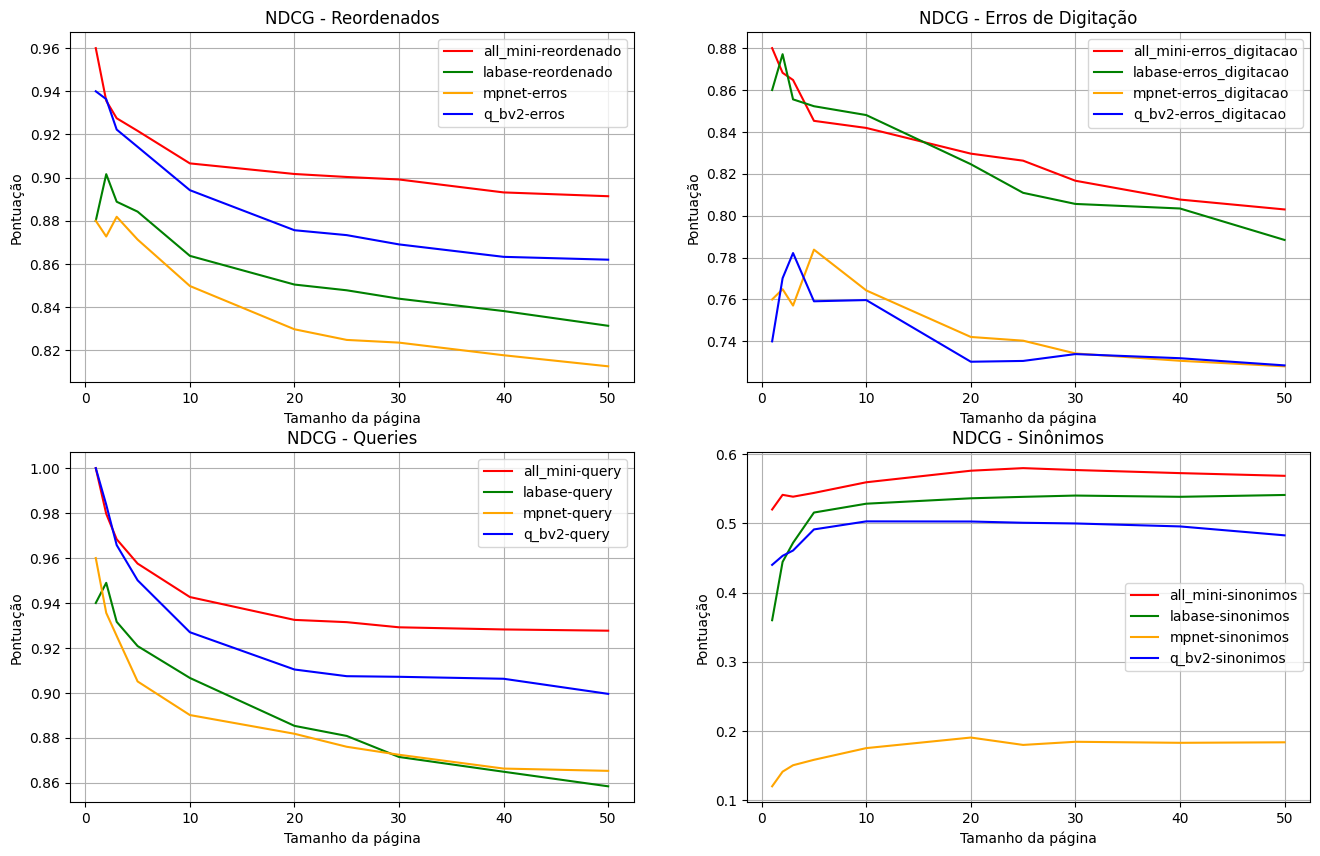

In [8]:
import matplotlib.pyplot as plt
import numpy as np
all_mini = grouped_nf[grouped_nf['abordagem'] == 'all_mini']   
labase = grouped_nf[grouped_nf['abordagem'] == 'labase']   
mpnet = grouped_nf[grouped_nf['abordagem'] == 'mpnet']   
q_bv2 = grouped_nf[grouped_nf['abordagem'] == 'q_bv2']   

semantico = grouped_nf[grouped_nf['abordagem'] == 'semantico']   
_, ax = plt.subplots(2, 2, figsize=(16,10)) 
ax[0,0].set_title('NDCG - Reordenados')
ax[0,0].set_xlabel('Tamanho da página')
ax[0,0].set_ylabel('Pontuação')
ax[0,0].plot(all_mini['size_page'], all_mini['ndcg_reordenados'], label='all_mini-reordenado', color='red', linestyle='-')
ax[0,0].plot(labase['size_page'], labase['ndcg_reordenados'], label='labase-reordenado', color='green', linestyle='-'  )
ax[0,0].plot(mpnet['size_page'], mpnet['ndcg_reordenados'], label='mpnet-erros', color='orange', linestyle='-')
ax[0,0].plot(q_bv2['size_page'], q_bv2['ndcg_reordenados'], label='q_bv2-erros', color='blue', linestyle='-'  )
ax[0,0].legend()
ax[0,0].grid('major')

ax[0,1].set_title('NDCG - Erros de Digitação')
ax[0,1].set_xlabel('Tamanho da página')
ax[0,1].set_ylabel('Pontuação')
ax[0,1].plot(all_mini['size_page'], all_mini['ndcg_erros_digitacao'], label='all_mini-erros_digitacao', color='red', linestyle='-')
ax[0,1].plot(labase['size_page'], labase['ndcg_erros_digitacao'], label='labase-erros_digitacao', color='green', linestyle='-'  )
ax[0,1].plot(mpnet['size_page'], mpnet['ndcg_erros_digitacao'], label='mpnet-erros_digitacao', color='orange', linestyle='-')
ax[0,1].plot(q_bv2['size_page'], q_bv2['ndcg_erros_digitacao'], label='q_bv2-erros_digitacao', color='blue', linestyle='-'  )
ax[0,1].legend()
ax[0,1].grid('major')

ax[1,0].set_title('NDCG - Queries')
ax[1,0].set_xlabel('Tamanho da página')
ax[1,0].set_ylabel('Pontuação')
ax[1,0].plot(all_mini['size_page'], all_mini['ndcg_query'], label='all_mini-query', color='red', linestyle='-')
ax[1,0].plot(labase['size_page'], labase['ndcg_query'], label='labase-query', color='green', linestyle='-'  )
ax[1,0].plot(mpnet['size_page'], mpnet['ndcg_query'], label='mpnet-query', color='orange', linestyle='-')
ax[1,0].plot(q_bv2['size_page'], q_bv2['ndcg_query'], label='q_bv2-query', color='blue', linestyle='-'  )
ax[1,0].legend()
ax[1,0].grid('major')

ax[1,1].set_title('NDCG - Sinônimos')
ax[1,1].set_xlabel('Tamanho da página')
ax[1,1].set_ylabel('Pontuação')
ax[1,1].plot(all_mini['size_page'], all_mini['ndcg_sinonimos'], label='all_mini-sinonimos', color='red', linestyle='-')
ax[1,1].plot(labase['size_page'], labase['ndcg_sinonimos'], label='labase-sinonimos', color='green', linestyle='-'  )
ax[1,1].plot(mpnet['size_page'], mpnet['ndcg_sinonimos'], label='mpnet-sinonimos', color='orange', linestyle='-')
ax[1,1].plot(q_bv2['size_page'], q_bv2['ndcg_sinonimos'], label='q_bv2-sinonimos', color='blue', linestyle='-'  )
ax[1,1].legend()
ax[1,1].grid('major')



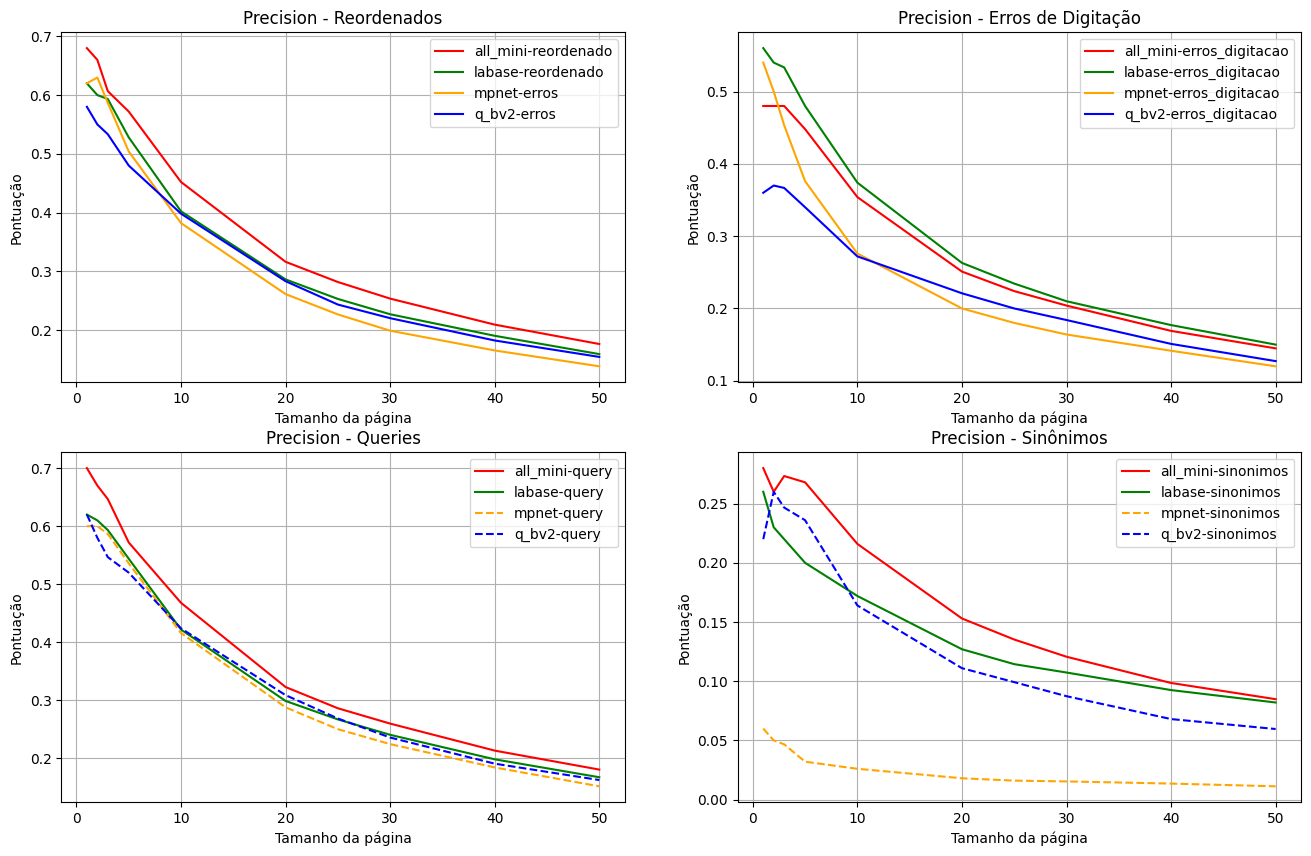

In [9]:
import matplotlib.pyplot as plt
import numpy as np
all_mini = grouped_nf[grouped_nf['abordagem'] == 'all_mini']   
labase = grouped_nf[grouped_nf['abordagem'] == 'labase']   
mpnet = grouped_nf[grouped_nf['abordagem'] == 'mpnet']   
q_bv2 = grouped_nf[grouped_nf['abordagem'] == 'q_bv2']   

semantico = grouped_nf[grouped_nf['abordagem'] == 'semantico']   
_, ax = plt.subplots(2, 2, figsize=(16,10)) 
ax[0,0].set_title('Precision - Reordenados')
ax[0,0].set_xlabel('Tamanho da página')
ax[0,0].set_ylabel('Pontuação')
ax[0,0].plot(all_mini['size_page'], all_mini['precision_reordenados'], label='all_mini-reordenado', color='red', linestyle='-')
ax[0,0].plot(labase['size_page'], labase['precision_reordenados'], label='labase-reordenado', color='green', linestyle='-'  )
ax[0,0].plot(mpnet['size_page'], mpnet['precision_reordenados'], label='mpnet-erros', color='orange', linestyle='-')
ax[0,0].plot(q_bv2['size_page'], q_bv2['precision_reordenados'], label='q_bv2-erros', color='blue', linestyle='-'  )
ax[0,0].legend()
ax[0,0].grid('major')

ax[0,1].set_title('Precision - Erros de Digitação')
ax[0,1].set_xlabel('Tamanho da página')
ax[0,1].set_ylabel('Pontuação')
ax[0,1].plot(all_mini['size_page'], all_mini['precision_erros_digitacao'], label='all_mini-erros_digitacao', color='red', linestyle='-')
ax[0,1].plot(labase['size_page'], labase['precision_erros_digitacao'], label='labase-erros_digitacao', color='green', linestyle='-'  )
ax[0,1].plot(mpnet['size_page'], mpnet['precision_erros_digitacao'], label='mpnet-erros_digitacao', color='orange', linestyle='-')
ax[0,1].plot(q_bv2['size_page'], q_bv2['precision_erros_digitacao'], label='q_bv2-erros_digitacao', color='blue', linestyle='-'  )
ax[0,1].legend()
ax[0,1].grid('major')

ax[1,0].set_title('Precision - Queries')
ax[1,0].set_xlabel('Tamanho da página')
ax[1,0].set_ylabel('Pontuação')
ax[1,0].plot(all_mini['size_page'], all_mini['precision_query'], label='all_mini-query', color='red', linestyle='-')
ax[1,0].plot(labase['size_page'], labase['precision_query'], label='labase-query', color='green', linestyle='-'  )
ax[1,0].plot(mpnet['size_page'], mpnet['precision_query'], label='mpnet-query', color='orange', linestyle='-')
ax[1,0].plot(q_bv2['size_page'], q_bv2['precision_query'], label='q_bv2-query', color='blue', linestyle='-'  )
ax[1,0].legend()
ax[1,0].grid('major')

ax[1,1].set_title('Precision - Sinônimos')
ax[1,1].set_xlabel('Tamanho da página')
ax[1,1].set_ylabel('Pontuação')
ax[1,1].plot(all_mini['size_page'], all_mini['precision_sinonimos'], label='all_mini-sinonimos', color='red', linestyle='-')
ax[1,1].plot(labase['size_page'], labase['precision_sinonimos'], label='labase-sinonimos', color='green', linestyle='-'  )
ax[1,1].plot(mpnet['size_page'], mpnet['precision_sinonimos'], label='mpnet-sinonimos', color='orange', linestyle='-')
ax[1,1].plot(q_bv2['size_page'], q_bv2['precision_sinonimos'], label='q_bv2-sinonimos', color='blue', linestyle='-'  )
ax[1,1].legend()
ax[1,1].grid('major')



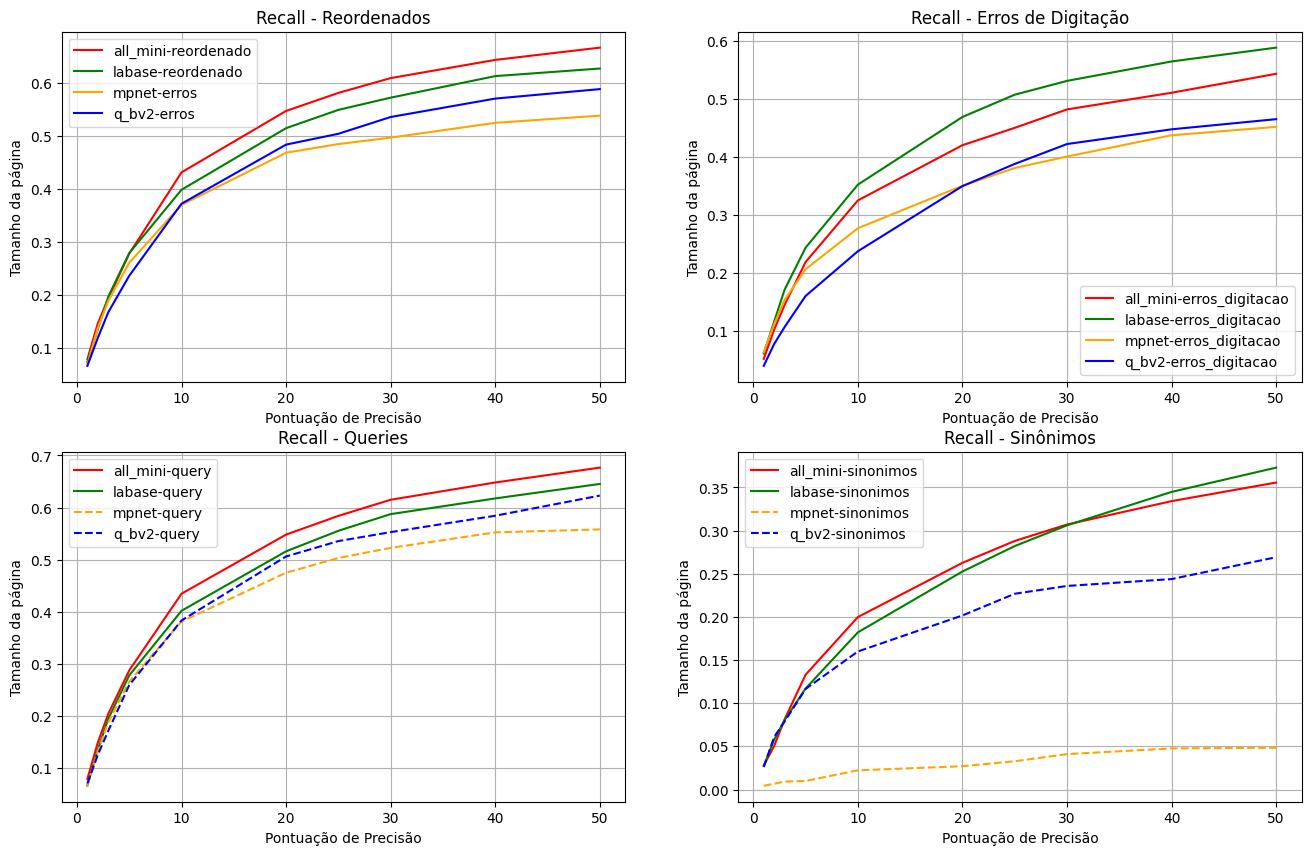

In [28]:
import matplotlib.pyplot as plt
import numpy as np
all_mini = grouped_nf[grouped_nf['abordagem'] == 'all_mini']   
labase = grouped_nf[grouped_nf['abordagem'] == 'labase']   
mpnet = grouped_nf[grouped_nf['abordagem'] == 'mpnet']   
q_bv2 = grouped_nf[grouped_nf['abordagem'] == 'q_bv2']   

semantico = grouped_nf[grouped_nf['abordagem'] == 'semantico']   
_, ax = plt.subplots(2, 2, figsize=(16,10)) 
ax[0,0].set_title('Recall - Reordenados')
ax[0,0].set_xlabel('Tamanho da página')
ax[0,0].set_ylabel('Pontuação')
ax[0,0].plot(all_mini['size_page'], all_mini['recall_reordenados'], label='all_mini-reordenado', color='red', linestyle='-')
ax[0,0].plot(labase['size_page'], labase['recall_reordenados'], label='labase-reordenado', color='green', linestyle='-'  )
ax[0,0].plot(mpnet['size_page'], mpnet['recall_reordenados'], label='mpnet-erros', color='orange', linestyle='-')
ax[0,0].plot(q_bv2['size_page'], q_bv2['recall_reordenados'], label='q_bv2-erros', color='blue', linestyle='-'  )
ax[0,0].legend()
ax[0,0].grid('major')

ax[0,1].set_title('Recall - Erros de Digitação')
ax[0,1].set_xlabel('Tamanho da página')
ax[0,1].set_ylabel('Pontuação')
ax[0,1].plot(all_mini['size_page'], all_mini['recall_erros_digitacao'], label='all_mini-erros_digitacao', color='red', linestyle='-')
ax[0,1].plot(labase['size_page'], labase['recall_erros_digitacao'], label='labase-erros_digitacao', color='green', linestyle='-'  )
ax[0,1].plot(mpnet['size_page'], mpnet['recall_erros_digitacao'], label='mpnet-erros_digitacao', color='orange', linestyle='-')
ax[0,1].plot(q_bv2['size_page'], q_bv2['recall_erros_digitacao'], label='q_bv2-erros_digitacao', color='blue', linestyle='-'  )
ax[0,1].legend()
ax[0,1].grid('major')

ax[1,0].set_title('Recall - Queries')
ax[1,0].set_xlabel('Tamanho da página')
ax[1,0].set_ylabel('Pontuação')
ax[1,0].plot(all_mini['size_page'], all_mini['recall_query'], label='all_mini-query', color='red', linestyle='-')
ax[1,0].plot(labase['size_page'], labase['recall_query'], label='labase-query', color='green', linestyle='-'  )
ax[1,0].plot(mpnet['size_page'], mpnet['recall_query'], label='mpnet-query', color='orange', linestyle='-')
ax[1,0].plot(q_bv2['size_page'], q_bv2['recall_query'], label='q_bv2-query', color='blue', linestyle='-'  )
ax[1,0].legend()
ax[1,0].grid('major')

ax[1,1].set_title('Recall - Sinônimos')
ax[1,1].set_xlabel('Tamanho da página')
ax[1,1].set_ylabel('Pontuação')
ax[1,1].plot(all_mini['size_page'], all_mini['recall_sinonimos'], label='all_mini-sinonimos', color='red', linestyle='-')
ax[1,1].plot(labase['size_page'], labase['recall_sinonimos'], label='labase-sinonimos', color='green', linestyle='-'  )
ax[1,1].plot(mpnet['size_page'], mpnet['recall_sinonimos'], label='mpnet-sinonimos', color='orange', linestyle='-')
ax[1,1].plot(q_bv2['size_page'], q_bv2['recall_sinonimos'], label='q_bv2-sinonimos', color='blue', linestyle='-'  )
ax[1,1].legend()
ax[1,1].grid('major')



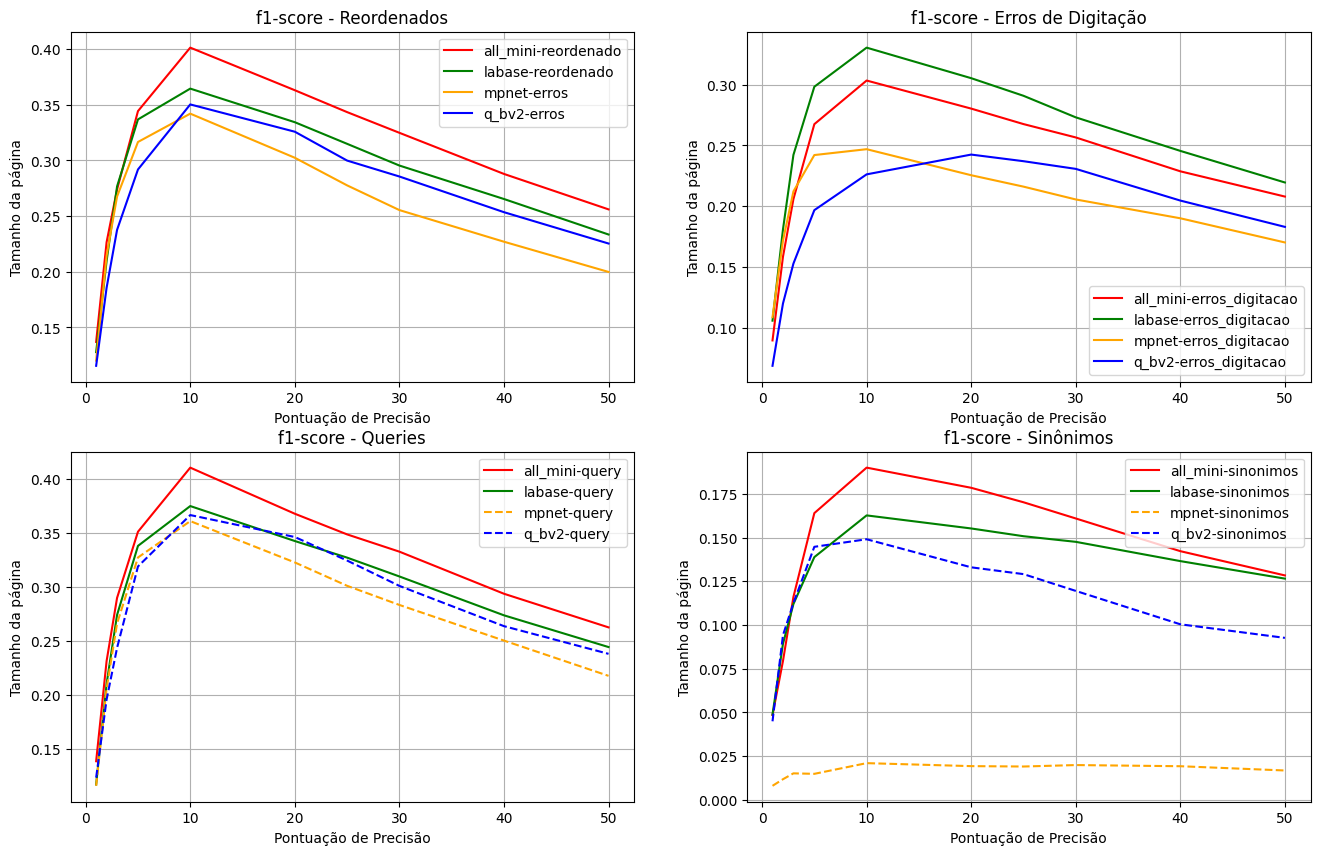

In [29]:
import matplotlib.pyplot as plt
import numpy as np
all_mini = grouped_nf[grouped_nf['abordagem'] == 'all_mini']   
labase = grouped_nf[grouped_nf['abordagem'] == 'labase']   
mpnet = grouped_nf[grouped_nf['abordagem'] == 'mpnet']   
q_bv2 = grouped_nf[grouped_nf['abordagem'] == 'q_bv2']   

semantico = grouped_nf[grouped_nf['abordagem'] == 'semantico']   
_, ax = plt.subplots(2, 2, figsize=(16,10)) 
ax[0,0].set_title('f1-score - Reordenados')
ax[0,0].set_xlabel('Tamanho da página')
ax[0,0].set_ylabel('Pontuação')
ax[0,0].plot(all_mini['size_page'], all_mini['f1-score_reordenados'], label='all_mini-reordenado', color='red', linestyle='-')
ax[0,0].plot(labase['size_page'], labase['f1-score_reordenados'], label='labase-reordenado', color='green', linestyle='-'  )
ax[0,0].plot(mpnet['size_page'], mpnet['f1-score_reordenados'], label='mpnet-erros', color='orange', linestyle='-')
ax[0,0].plot(q_bv2['size_page'], q_bv2['f1-score_reordenados'], label='q_bv2-erros', color='blue', linestyle='-'  )
ax[0,0].legend()
ax[0,0].grid('major')

ax[0,1].set_title('f1-score - Erros de Digitação')
ax[0,1].set_xlabel('Tamanho da página')
ax[0,1].set_ylabel('Pontuação')
ax[0,1].plot(all_mini['size_page'], all_mini['f1-score_erros_digitacao'], label='all_mini-erros_digitacao', color='red', linestyle='-')
ax[0,1].plot(labase['size_page'], labase['f1-score_erros_digitacao'], label='labase-erros_digitacao', color='green', linestyle='-'  )
ax[0,1].plot(mpnet['size_page'], mpnet['f1-score_erros_digitacao'], label='mpnet-erros_digitacao', color='orange', linestyle='-')
ax[0,1].plot(q_bv2['size_page'], q_bv2['f1-score_erros_digitacao'], label='q_bv2-erros_digitacao', color='blue', linestyle='-'  )
ax[0,1].legend()
ax[0,1].grid('major')

ax[1,0].set_title('f1-score - Queries')
ax[1,0].set_xlabel('Tamanho da página')
ax[1,0].set_ylabel('Pontuação')
ax[1,0].plot(all_mini['size_page'], all_mini['f1-score_query'], label='all_mini-query', color='red', linestyle='-')
ax[1,0].plot(labase['size_page'], labase['f1-score_query'], label='labase-query', color='green', linestyle='-'  )
ax[1,0].plot(mpnet['size_page'], mpnet['f1-score_query'], label='mpnet-query', color='orange', linestyle='-')
ax[1,0].plot(q_bv2['size_page'], q_bv2['f1-score_query'], label='q_bv2-query', color='blue', linestyle='-'  )
ax[1,0].legend()
ax[1,0].grid('major')

ax[1,1].set_title('f1-score - Sinônimos')
ax[1,1].set_xlabel('Tamanho da página')
ax[1,1].set_ylabel('Pontuação')
ax[1,1].plot(all_mini['size_page'], all_mini['f1-score_sinonimos'], label='all_mini-sinonimos', color='red', linestyle='-')
ax[1,1].plot(labase['size_page'], labase['f1-score_sinonimos'], label='labase-sinonimos', color='green', linestyle='-'  )
ax[1,1].plot(mpnet['size_page'], mpnet['f1-score_sinonimos'], label='mpnet-sinonimos', color='orange', linestyle='-')
ax[1,1].plot(q_bv2['size_page'], q_bv2['f1-score_sinonimos'], label='q_bv2-sinonimos', color='blue', linestyle='-'  )
ax[1,1].legend()
ax[1,1].grid('major')



In [11]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import spacy

In [12]:
#!python -m spacy download pt_core_news_sm

nlp = spacy.load('pt_core_news_sm')
def custom_preprocessor(text):
    doc = nlp(text)
    lemmatized_words = [token.lemma_ for token in doc]
    return ' '.join(lemmatized_words)

In [13]:
tfidf_vectorizer = TfidfVectorizer(preprocessor=custom_preprocessor, lowercase=True, strip_accents='unicode', ngram_range=(1, 3))
tfidf_vectorizer.fit(df_unique_index_nf['DESCRICAO_PRODUTO'])

TfidfVectorizer(ngram_range=(1, 3),
                preprocessor=<function custom_preprocessor at 0x7fe01a458d60>,
                strip_accents='unicode')